In [2]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage

Using TensorFlow backend.


In [33]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
#path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"
#model = load_model(path + 'models/' + 'EDGEnet_run_epoch_4.h5')

model = load_model(path + 'models/' + 'EDGEnet2_runhn_epoch_7.h5')


In [49]:
sigma = 1.6
alpha = 0.3
Xi = 30
width = 20
space = 20
noise = 10
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

noisy_file = path + 'noisy_images/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
imnoisy = np.array(Image.open(noisy_file))

imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)

linepredict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
linepredict = linepredict.reshape(1024,2)
print(linepredict.shape)

(1024, 2)


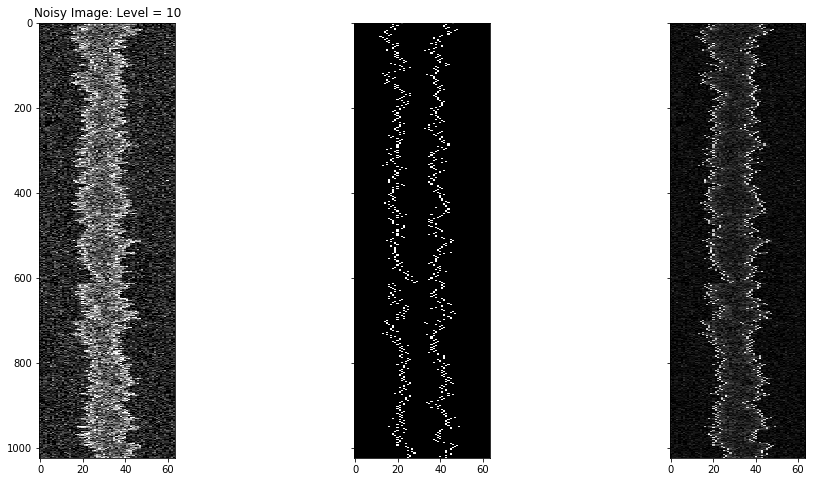

In [50]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0].set_title('Noisy Image: Level = {}'.format(noise))

edgepredict = np.zeros((1024,64))
i =[]
for i in range(1024):
    edgepredict[i, (linepredict*64).round().astype(int)[i,0]] = 1
    edgepredict[i, (linepredict*64).round().astype(int)[i,1]] = 1
    
ax[1].imshow(edgepredict, cmap = 'gray',aspect= 0.2)

ax[2].imshow(imnoisy + 2*edgepredict, cmap = 'gray',aspect= 0.2)

plt.show()


Original leftline sigma = 1.52355573146481, rightline sigma = 1.5744416715612037
Predicted leftline sigma = 1.511762199467445, rightline sigma = 1.5243483730241287
342
336


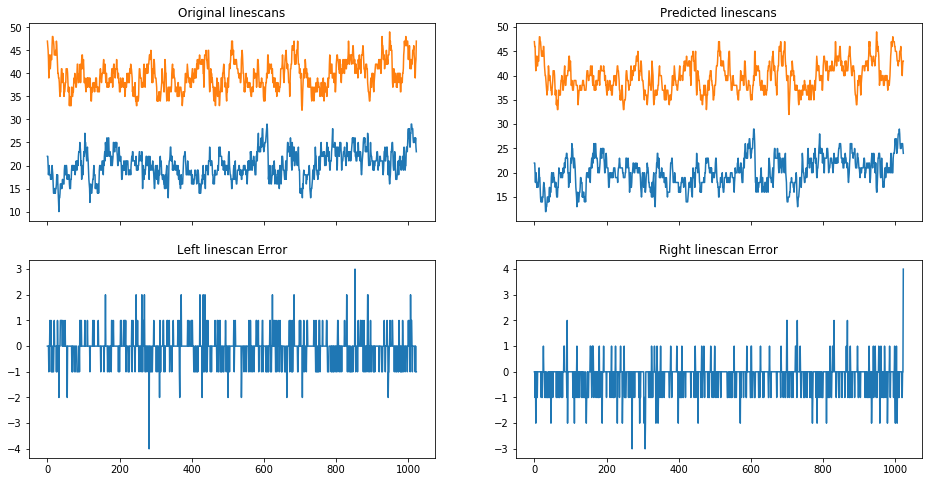

In [51]:
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

print('Original leftline sigma = {}, rightline sigma = {}'.format(leftline.astype(int).std()/2, \
                                                                  rightline.astype(int).std()/2))

print('Predicted leftline sigma = {}, rightline sigma = {}'.format((linepredict*64).round().astype(int)[:,0].std()/2, \
                                                                  (linepredict*64).round().astype(int)[:,1].std()/2))

print(np.abs(leftline.astype(int) - (linepredict*64).round().astype(int)[:,0]).sum())
print(np.abs(rightline.astype(int) - (linepredict*64).round().astype(int)[:,1]).sum())

ax[0,0].plot(leftline.astype(int))
ax[0,0].plot(rightline.astype(int))
ax[0,0].set_title('Original linescans')

ax[0,1].plot((linepredict*64).round().astype(int))
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.astype(int) - (linepredict*64).round().astype(int)[:,0])
ax[1,0].set_title('Left linescan Error')

ax[1,1].plot(rightline.astype(int) - (linepredict*64).round().astype(int)[:,1])
ax[1,1].set_title('Right linescan Error')
plt.show()
